# Synthetic gradients

Sam Greydanus | September 2017 | MIT License

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

In [2]:
class Mnist():
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.modes = modes = ['train', 'test']
        trans = transforms.Compose([transforms.ToTensor(),]) # transforms.Normalize((0.1307,), (0.3081,))
        dsets = {k: datasets.MNIST('./data', train=k=='train', download=True, transform=trans) for k in modes}
        self.loaders = {k: torch.utils.data.DataLoader(dsets[k], batch_size=batch_size, shuffle=True) for k in modes}

    def next(self, mode='train'):
        X, y = next(iter(self.loaders[mode]))
        return X.resize_(self.batch_size, 28**2).numpy(), y.numpy()

In [3]:
def get_accuracy(model, mnist, nsamples=10000, mode='test'):
    assert mode in mnist.modes, 'incorrect mode supplied'
    assert nsamples >= 10*mnist.batch_size
    pool_size, correct = 0, 0
    total_correct = 0 ; total = 0 ; acc_list = []
    nbatches = int(nsamples/mnist.batch_size)
    for _ in range(nbatches):
        pool_size += mnist.batch_size
        X, y = mnist.next(mode)
        y_hat = model(X)
        correct += sum(y_hat.argmax(axis=1) == y)
        if pool_size > nsamples/10:
            acc_list.append(100*correct/pool_size)
            total_correct += correct
            pool_size, correct = 0, 0
    mean, std = 100*total_correct/(nbatches*mnist.batch_size), np.std(acc_list)
    return mean, std

In [4]:
def forward(X, model):
    # evaluate class scores, [N x K]
    saved = {'X': X.copy()}
    
    h1 = np.dot(X, model['W1']) + model['b1'] # linear layer
    h1[h1<0] = 0 # relu
    saved['h1'] = h1
    
    h2 = np.dot(h1, model['W2']) + model['b2'] # linear layer
    h2[h2<0] = 0 # relu
    saved['h2'] = h2
    
    e = np.exp(h2 - np.amax(h2, axis=1, keepdims=True))
    probs = e / np.sum(e, axis=1, keepdims=True) # softmax cap
    return probs, saved

In [5]:
def backward(y, y_hat, model, saved, smodel=None, use_stale_dhs=False):
    batch_size = y.shape[0]
    grad = { k : np.zeros_like(v) for k,v in model.items() }
    
    # negative log likelihood
    nll_loss = -np.log(y_hat[range(batch_size),y]).mean()
    y_hat[range(batch_size),y] -= 1 # backwards through softmax
    saved['dh2'] = y_hat/batch_size
    
    # second hidden layer
    grad['W2'] = np.dot(saved['h1'].T, saved['dh2'])
    grad['b2'] = np.sum(saved['dh2'], axis=0, keepdims=True)

    # first hidden layer
    if smodel is None and not use_stale_dhs:
        saved['dh1'] = np.dot(saved['dh2'], model['W2'].T)   # backwards through linear layer
        saved['dh1'][saved['h1'] <= 0] = 0                   # backwards through relu
    else:
        saved['dh1'] = np.dot(saved['h1'], smodel['W1']) + smodel['b1'] # THE SYNTHETIC GRAD PART
        
    grad['W1'] = np.dot(saved['X'].T, saved['dh1'])
    grad['b1'] = np.sum(saved['dh1'], axis=0, keepdims=True)
    return nll_loss, grad

In [6]:
def sbackward(saved_bp, saved_synth, smodel, saved):
    sgrad = { k : np.zeros_like(v) for k,v in smodel.items() }
    d_target = saved_synth['dh1'] - saved_bp['dh1']
    sloss = (d_target**2).mean() # l2 loss
    
    sgrad['W1'] += np.dot(saved_bp['h1'].T, d_target)
    sgrad['b1'] += np.sum(d_target, axis=0, keepdims=True)
    return sloss, sgrad

In [7]:
def train(model, smodel, mnist, args, horizon=20):
    loss_hist = [] ; acc_hist = []
    rmsprop = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop gradient cache
    for step in range(args['max_steps'] + 1):
        
        X, y = mnist.next()
        y_hat, saved = forward(X, model)
        
        # get REAL loss and SYNTHETIC grad
        loss, grad = backward(y, y_hat.copy(), model, saved, smodel, use_stale_dhs=args['use_synth_grad'])
        
        # upgrade synthetic grad model
        if step % args['real_grad_every'] == 0 or step < 100:
            saved_synth = saved.copy()
            loss, grad = backward(y, y_hat.copy(), model, saved, smodel=None) # get REAL loss and REAL grad
            saved_bp = saved.copy()
            sloss, sgrad = sbackward(saved_bp, saved_synth, smodel, saved)
            
            # update synthetic model and regular model
            smodel = {k : smodel[k] - args['lr']*sgrad[k] for (k,v) in sgrad.items()}
            
        # parameter update
        for k,v in model.items():
            rmsprop[k] = args['rms_decay'] * rmsprop[k] + (1-args['rms_decay']) * grad[k]**2
            if step > 100: model[k] -= args['lr'] * grad[k] / (np.sqrt(rmsprop[k]) + 1e-5)
        
        # bookkeeping
        end = '\r'
        loss_hist += [loss]
        run_loss = sum(loss_hist[-horizon:])/min(horizon, step+1)
        if step % args['test_every'] == 0:
            get_y_hat = lambda X: forward(X, model)[0]
            acc, acc_std = get_accuracy(model=get_y_hat, mnist=mnist)
            acc_hist += [[acc, acc_std]] ; end = '\n'
        print('step {} | loss {:.4f} | sloss {:.4f} | acc {:.2f}% +/- {:.2f}'\
              .format(step, run_loss, sloss, acc, acc_std), end=end)
        
    return model, loss_hist, acc_hist

In [13]:
np.random.seed(1)
args = {'batch_size': 128, 'lr': 1e-4, 'slr': 5e-4,
        'rms_decay': 0.9, 'use_synth_grad': True,
        'real_grad_every': 10, 'h_size': 128, 'test_every': 500,
        'max_steps': 20000, 'save_dir': './save/'}

model = {}
# first layer
model['W1'] = np.random.randn(28**2, args['h_size']) / np.sqrt(args['h_size']) # Xavier initialization
model['b1'] = np.zeros((1,args['h_size']))
model['W2'] = np.random.randn(args['h_size'],10) / np.sqrt(10)
model['b2'] = np.zeros((1,10))

# simplest possible synthetic gradient model
smodel = {}
smodel['W1'] = np.random.randn(args['h_size'], args['h_size']) / 1000*np.sqrt(args['h_size']) # Xavier initialization
smodel['b1'] = np.zeros((1,args['h_size']))

mnist = Mnist(args['batch_size'])
model, loss_hist, acc_hist = train(model, smodel, mnist, args)

step 0 | loss 2.4495 | sloss 0.0056 | acc 14.63% +/- 0.78
step 500 | loss 2.2617 | sloss 0.0013 | acc 20.21% +/- 1.55
step 1000 | loss 1.8909 | sloss 0.0012 | acc 38.99% +/- 1.46
step 1500 | loss 1.5282 | sloss 0.0011 | acc 50.89% +/- 1.63
step 2000 | loss 1.3576 | sloss 0.0009 | acc 56.30% +/- 1.54
step 2500 | loss 1.2664 | sloss 0.0007 | acc 61.39% +/- 1.37
step 3000 | loss 1.1686 | sloss 0.0006 | acc 64.14% +/- 1.91
step 3500 | loss 1.0784 | sloss 0.0005 | acc 65.98% +/- 0.92
step 4000 | loss 1.0126 | sloss 0.0005 | acc 67.65% +/- 1.24
step 4500 | loss 0.9041 | sloss 0.0004 | acc 70.54% +/- 1.19
step 5000 | loss 0.8006 | sloss 0.0003 | acc 72.33% +/- 1.37
step 5500 | loss 0.7861 | sloss 0.0005 | acc 72.95% +/- 0.86
step 6000 | loss 0.6961 | sloss 0.0004 | acc 73.36% +/- 1.09
step 6500 | loss 0.7221 | sloss 0.0038 | acc 75.33% +/- 0.52
step 7000 | loss 0.6787 | sloss 0.0124 | acc 75.77% +/- 1.32
step 7500 | loss 0.6248 | sloss 0.0413 | acc 76.23% +/- 1.04
step 8000 | loss 0.6224 | sl

In [14]:
np.random.seed(1)
args['use_synth_grad'] = False

model = {}
# first layer
model['W1'] = np.random.randn(28**2, args['h_size']) / np.sqrt(args['h_size']) # Xavier initialization
model['b1'] = np.zeros((1,args['h_size']))
model['W2'] = np.random.randn(args['h_size'],10) / np.sqrt(10)
model['b2'] = np.zeros((1,10))

# simplest possible synthetic gradient model
smodel = {}
smodel['W1'] = np.random.randn(args['h_size'], args['h_size']) / 1000*np.sqrt(args['h_size']) # Xavier initialization
smodel['b1'] = np.zeros((1,args['h_size']))

mnist = Mnist(args['batch_size'])
model, loss_hist_cont, acc_hist_cont = train(model, smodel, mnist, args)

step 0 | loss 2.3332 | sloss 0.0054 | acc 15.13% +/- 0.85
step 500 | loss 2.2680 | sloss 0.0012 | acc 21.42% +/- 1.21
step 1000 | loss 1.8428 | sloss 0.0012 | acc 37.95% +/- 1.88
step 1500 | loss 1.5311 | sloss 0.0011 | acc 49.89% +/- 1.23
step 2000 | loss 1.3349 | sloss 0.0009 | acc 55.37% +/- 0.99
step 2500 | loss 1.1120 | sloss 0.0008 | acc 60.99% +/- 1.70
step 3000 | loss 1.0477 | sloss 0.0007 | acc 64.42% +/- 1.60
step 3500 | loss 1.0043 | sloss 0.0006 | acc 66.91% +/- 2.01
step 4000 | loss 0.9293 | sloss 0.0005 | acc 68.50% +/- 0.75
step 4500 | loss 0.8436 | sloss 0.0004 | acc 69.18% +/- 1.09
step 5000 | loss 0.8470 | sloss 0.0003 | acc 71.10% +/- 1.21
step 5500 | loss 0.8111 | sloss 0.0003 | acc 72.49% +/- 1.44
step 6000 | loss 0.7642 | sloss 0.0003 | acc 73.19% +/- 1.38
step 6500 | loss 0.7289 | sloss 0.0002 | acc 74.06% +/- 1.49
step 7000 | loss 0.7315 | sloss 0.0002 | acc 74.08% +/- 0.72
step 7500 | loss 0.6980 | sloss 0.0002 | acc 74.80% +/- 0.71
step 8000 | loss 0.6787 | sl

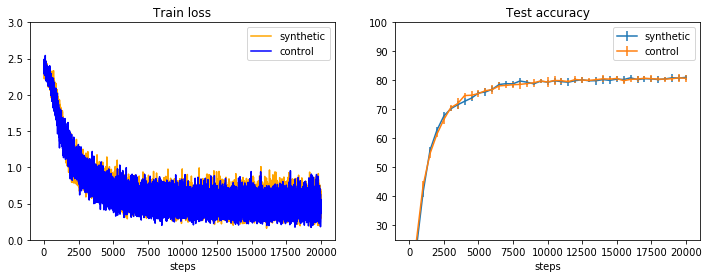

In [11]:
loss_data = np.vstack(loss_hist)
acc_data = np.vstack(acc_hist)

loss_data_cont = np.vstack(loss_hist_cont)
acc_data_cont = np.vstack(acc_hist_cont)

f = plt.figure(figsize=[12,4])
plt.subplot(1,2,1) ; plt.title("Train loss") ; plt.xlabel("steps")
plt.plot(range(len(loss_hist)), loss_data, 'orange', label='synthetic')
plt.plot(range(len(loss_hist_cont)), loss_data_cont, 'blue', label='control')
plt.ylim([0,3])
plt.legend()

plt.subplot(1,2,2) ; plt.title("Test accuracy") ; plt.xlabel("steps")
plt.errorbar(range(len(loss_hist))[::500], acc_data[:,0], yerr=acc_data[:,1], errorevery=1, label='synthetic')
plt.errorbar(range(len(loss_hist_cont))[::500], acc_data_cont[:,0], yerr=acc_data_cont[:,1], errorevery=1, label='control')
plt.ylim([25,100])
plt.legend()
plt.show() ; f.savefig('./static/synthetic.png', bbox_inches='tight')

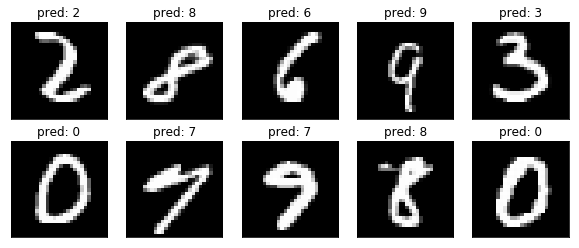

In [12]:
X, y = mnist.next()
y_hat, saved = forward(X, model)
predictions = y_hat.argmax(axis=1)

rows = 2
cols = 5
side = 2
f = plt.figure(figsize=[cols*side,rows*side])
for r in range(rows):
    for c in range(cols):
        img_ix = r*cols + c
        plt.subplot(rows, cols, img_ix+1)
        plt.title("pred: {}".format(predictions[img_ix]))
        plt.imshow(X[img_ix].reshape(28,28), cmap='gray')
        
        f.axes[img_ix].get_xaxis().set_visible(False)
        f.axes[img_ix].get_yaxis().set_visible(False)
plt.show()